### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import cv2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import datetime
import os

import warnings
warnings.filterwarnings("ignore")



Ładowanie i wstępne przetwarzanie obrazów

In [10]:
img = cv2.imread(r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\disco\3_0.jpg")
type(img)

numpy.ndarray

In [11]:
print(img.shape,img.dtype)

(400, 400, 3) uint8


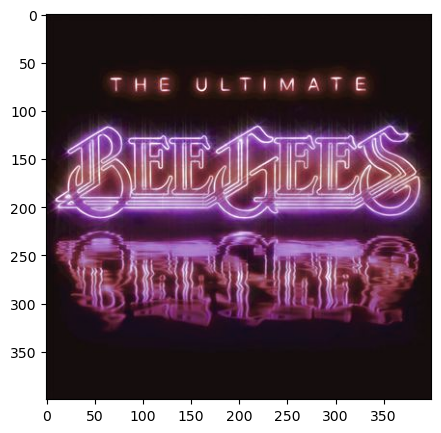

In [12]:
fig = plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

https://www.kaggle.com/datasets/anastasiapetrunia/album-covers-dataset/download?datasetVersionNumber=9

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=gIjgz7_JIo_m

In [2]:
path = r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled"

In [3]:
categories = ['disco', 'electro', 'folk', 'rap', 'rock']

def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fr'C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\{category}'): #path to the folders with data
            img = cv2.imread(fr'C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\{category}/{image_name}') #path to the folders
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img, (180,180))
            img_lst.append(img_array)
            labels.append(index)
    return img_lst, labels

img_lst, labels = load_images_and_labels(categories)

In [4]:
len(img_lst)

9311

In [5]:
len(labels)

9311

In [6]:
img_lst = np.array(img_lst)
labels = np.array(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(img_lst, labels, test_size=0.1, random_state=42)

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [8]:
print(f'Ilość zdjęć dla zbioru treningowego: {x_train.shape[0]}')
print(f'Ilość zdjęć dla zbioru trestowego: {x_test.shape[0]}')

Ilość zdjęć dla zbioru treningowego: 8379
Ilość zdjęć dla zbioru trestowego: 932


In [9]:
y_train

array([2, 0, 1, ..., 2, 0, 3])

In [10]:
# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)
y_train

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [11]:
y_test[:5]

array([4, 0, 1, 2, 1])

In [12]:
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)
y_test

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [13]:
print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)

y_test.shape:  (932, 5)
y_train.shape:  (8379, 5)


In [14]:
# sprawdzamy ilość wejściowych obrazow i ich shape
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (8379, 180, 180, 3)
x_test shape:  (932, 180, 180, 3)


In [15]:
x_train.shape

(8379, 180, 180, 3)

In [16]:
class_names = ['disco', 'electro', 'folk', 'rap', 'rock']
num_classes = len(class_names)

In [17]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [30]:
model_a = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[16,32],
    hNum=[200],
    hAct="relu",
    outNum=num_classes,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0         
                                                                 
 dense (Dense)               (None, 200)               1

In [18]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
history = model_a.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=10,
    validation_split=0.05,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
40/40 [==============================] - 45s 1s/step - loss: 4.3851 - accuracy: 0.2054 - val_loss: 1.6074 - val_accuracy: 0.2339
Epoch 2/10
40/40 [==============================] - 44s 1s/step - loss: 1.5782 - accuracy: 0.2688 - val_loss: 1.5324 - val_accuracy: 0.3150
Epoch 3/10
40/40 [==============================] - 40s 990ms/step - loss: 1.5089 - accuracy: 0.3410 - val_loss: 1.4757 - val_accuracy: 0.3628
Epoch 4/10
40/40 [==============================] - 40s 989ms/step - loss: 1.4119 - accuracy: 0.4172 - val_loss: 1.4457 - val_accuracy: 0.3723
Epoch 5/10
40/40 [==============================] - 46s 1s/step - loss: 1.2781 - accuracy: 0.4892 - val_loss: 1.4056 - val_accuracy: 0.4177
Epoch 6/10
40/40 [==============================] - 45s 1s/step - loss: 1.0818 - accuracy: 0.5874 - val_loss: 1.3801 - val_accuracy: 0.4153
Epoch 7/10
40/40 [==============================] - 51s 1s/step - loss: 0.8856 - accuracy: 0.6775 - val_loss: 1.4816 - val_accuracy: 0.3938
Epoch 8/10
40/

In [33]:
# jakie wartości przechowuje historia wyników
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

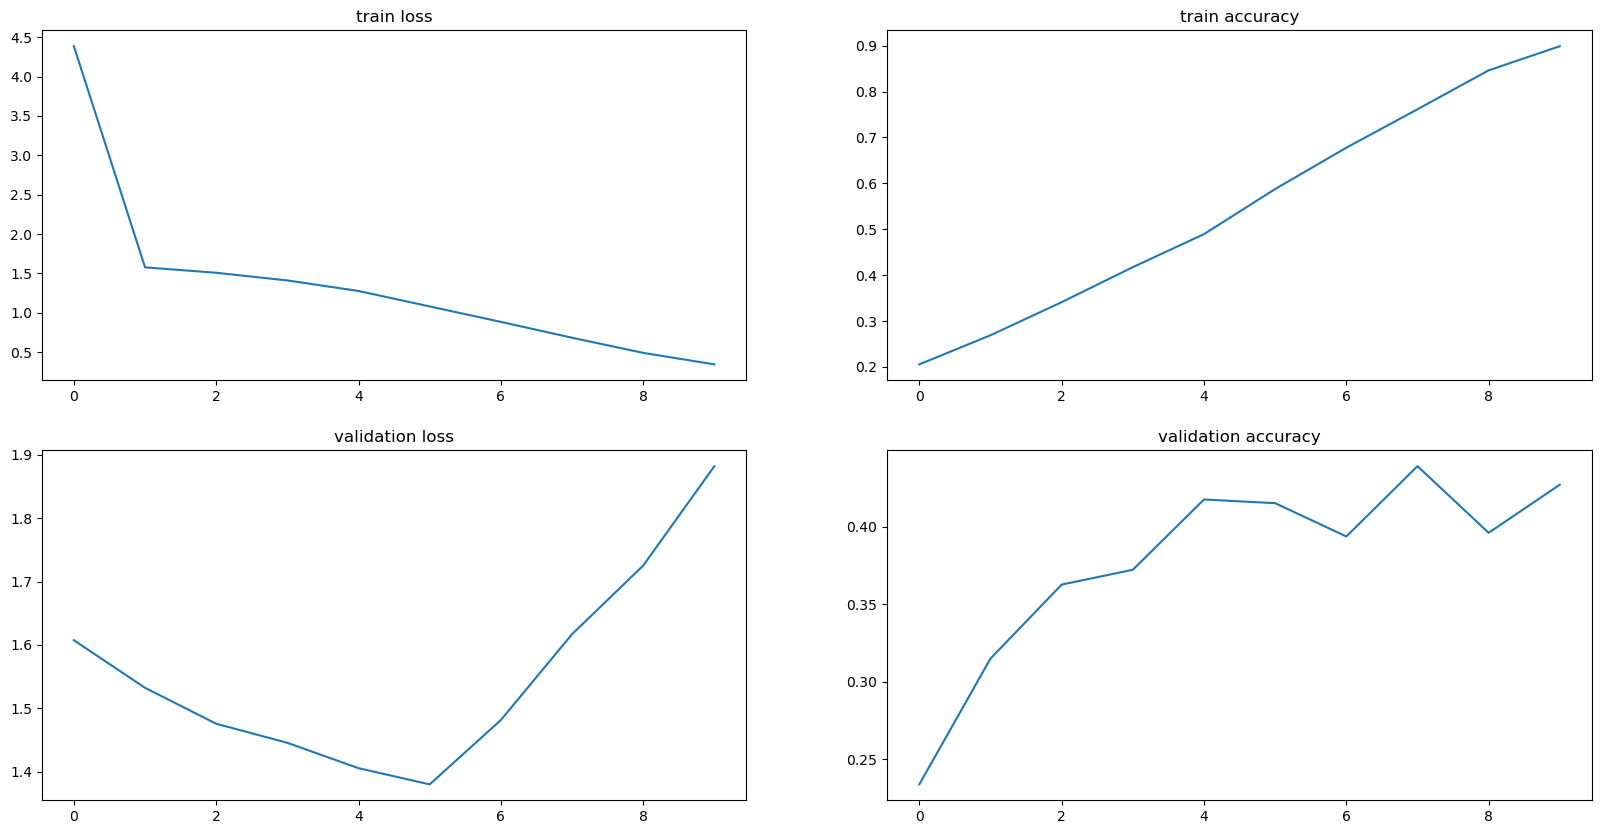

30/30 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       190
           1       0.44      0.49      0.47       184
           2       0.29      0.28      0.28       179
           3       0.50      0.51      0.51       193
           4       0.34      0.32      0.33       186

    accuracy                           0.41       932
   macro avg       0.40      0.41      0.41       932
weighted avg       0.41      0.41      0.41       932



In [34]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model_a.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [35]:
##podejrzenie widoku tensorboard'a
%load_ext tensorboard
%tensorboard --logdir "logs"

Reusing TensorBoard on port 6006 (pid 11792), started 0:16:36 ago. (Use '!kill 11792' to kill it.)

# 2

In [36]:
model_b = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[8,16,32,64],
    hNum=[32],
    hAct="relu",
    outNum=num_classes,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)      

In [37]:
history = model_a.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=10,
    validation_split=0.05
)

Epoch 1/10
40/40 [==============================] - 36s 780ms/step - loss: 0.2416 - accuracy: 0.9391 - val_loss: 2.2096 - val_accuracy: 0.4129
Epoch 2/10
40/40 [==============================] - 32s 813ms/step - loss: 0.1778 - accuracy: 0.9607 - val_loss: 2.3462 - val_accuracy: 0.4272
Epoch 3/10
40/40 [==============================] - 33s 818ms/step - loss: 0.1340 - accuracy: 0.9720 - val_loss: 2.5344 - val_accuracy: 0.4272
Epoch 4/10
40/40 [==============================] - 32s 808ms/step - loss: 0.1256 - accuracy: 0.9751 - val_loss: 2.6468 - val_accuracy: 0.4153
Epoch 5/10
40/40 [==============================] - 32s 799ms/step - loss: 0.1013 - accuracy: 0.9817 - val_loss: 2.7949 - val_accuracy: 0.4368
Epoch 6/10
40/40 [==============================] - 33s 818ms/step - loss: 0.1010 - accuracy: 0.9813 - val_loss: 2.7474 - val_accuracy: 0.4129
Epoch 7/10
40/40 [==============================] - 31s 787ms/step - loss: 0.0899 - accuracy: 0.9851 - val_loss: 2.8642 - val_accuracy: 0.4153

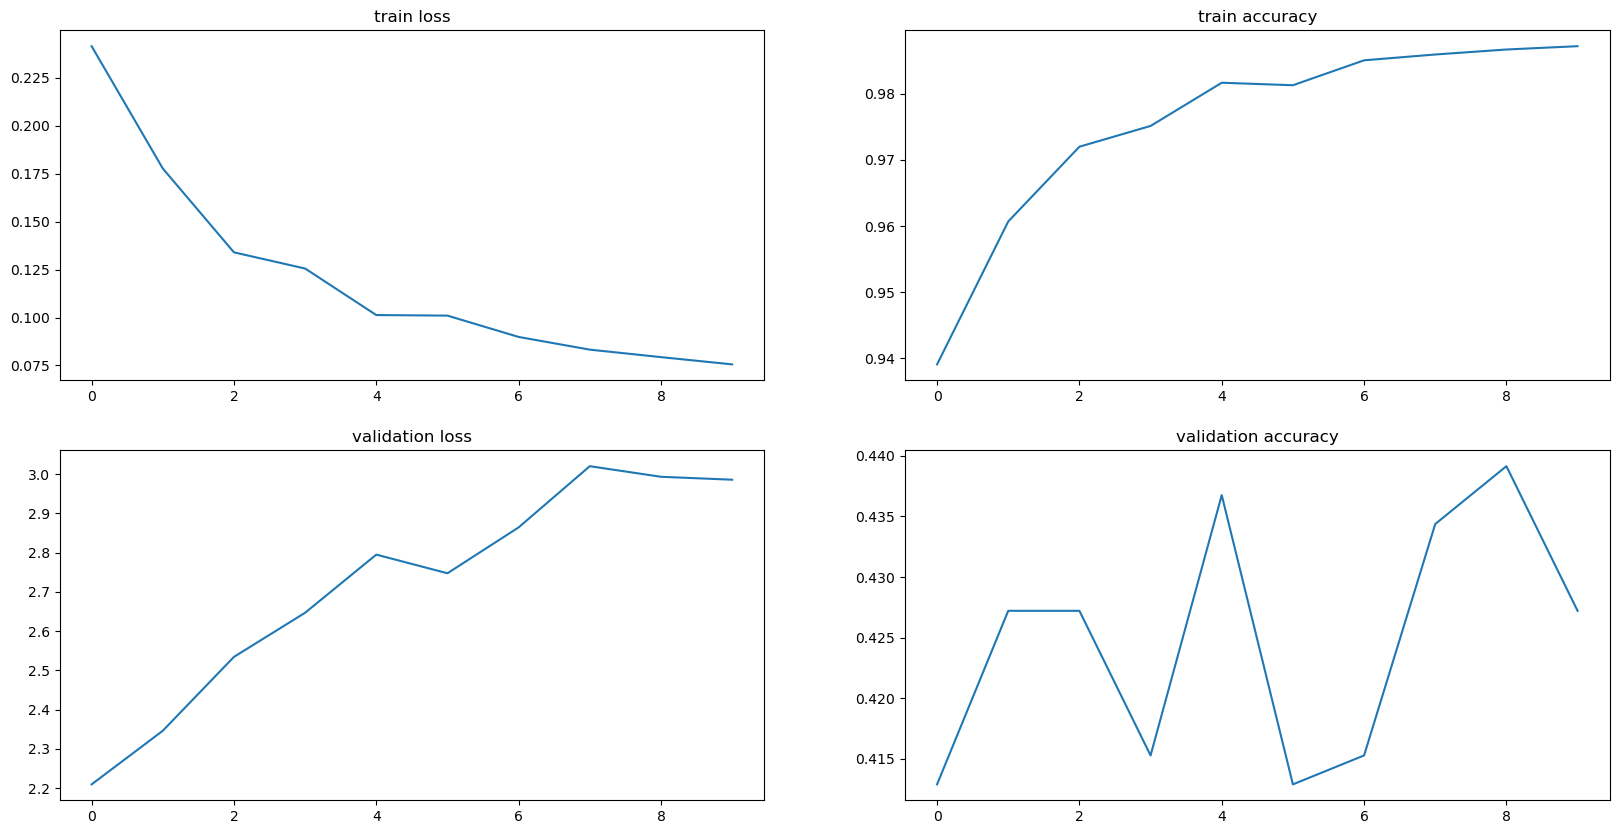

30/30 [==============================] - 1s 42ms/step
              precision    recall  f1-score   support

           0       0.40      0.43      0.41       190
           1       0.48      0.45      0.46       184
           2       0.29      0.36      0.32       179
           3       0.57      0.47      0.51       193
           4       0.33      0.28      0.30       186

    accuracy                           0.40       932
   macro avg       0.41      0.40      0.40       932
weighted avg       0.41      0.40      0.40       932



In [38]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model_a.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [25]:
#cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print(cm)

# 3

In [22]:
model_c = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[32,32,64,64],
    hNum=[200],
    hAct="relu",
    outNum=num_classes,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)      

In [23]:
history = model_c.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=10,
    validation_split=0.05
)

Epoch 1/10
40/40 [==============================] - 82s 2s/step - loss: 1.6237 - accuracy: 0.2402 - val_loss: 1.5863 - val_accuracy: 0.2840
Epoch 2/10
40/40 [==============================] - 80s 2s/step - loss: 1.5342 - accuracy: 0.3221 - val_loss: 1.4849 - val_accuracy: 0.3795
Epoch 3/10
40/40 [==============================] - 76s 2s/step - loss: 1.4573 - accuracy: 0.3741 - val_loss: 1.4323 - val_accuracy: 0.3986
Epoch 4/10
40/40 [==============================] - 80s 2s/step - loss: 1.3919 - accuracy: 0.4158 - val_loss: 1.3846 - val_accuracy: 0.4177
Epoch 5/10
40/40 [==============================] - 81s 2s/step - loss: 1.3314 - accuracy: 0.4592 - val_loss: 1.4021 - val_accuracy: 0.3890
Epoch 6/10
40/40 [==============================] - 78s 2s/step - loss: 1.2633 - accuracy: 0.4828 - val_loss: 1.4152 - val_accuracy: 0.4033
Epoch 7/10
40/40 [==============================] - 80s 2s/step - loss: 1.1431 - accuracy: 0.5437 - val_loss: 1.4372 - val_accuracy: 0.4081
Epoch 8/10
40/40 [==

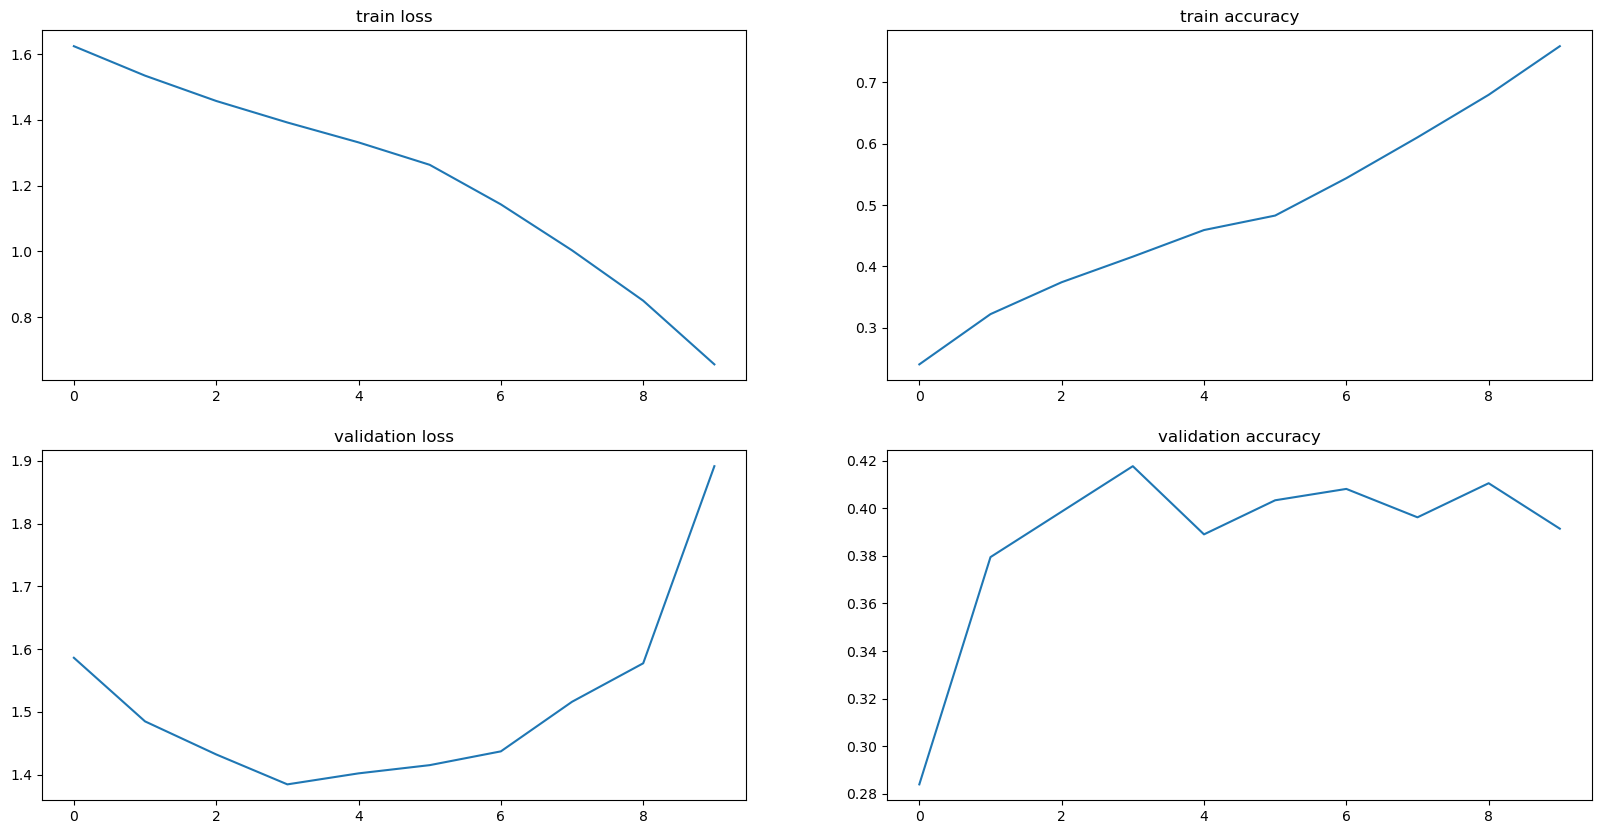

30/30 [==============================] - 4s 111ms/step
              precision    recall  f1-score   support

           0       0.42      0.31      0.36       190
           1       0.48      0.42      0.45       184
           2       0.30      0.35      0.32       179
           3       0.53      0.52      0.52       193
           4       0.28      0.35      0.32       186

    accuracy                           0.39       932
   macro avg       0.40      0.39      0.39       932
weighted avg       0.41      0.39      0.40       932



In [24]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model_c.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Transfer Learning

In [29]:
batch_size = 64
img_height = 224
img_width = 224

data_dir=r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled" 
# path to the folders with data on my drive


train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9311 files belonging to 5 classes.
Using 8380 files for training.
Found 9311 files belonging to 5 classes.
Using 931 files for validation.


In [30]:
class_names = train_ds.class_names # in this method labels are generated from the directory structure
print(class_names)
print(len(class_names))

['disco', 'electro', 'folk', 'rap', 'rock']
5


In [31]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [32]:
image_batch.shape

TensorShape([64, 224, 224, 3])

In [33]:
labels_batch.shape

TensorShape([64])

In [34]:
normalization_layer = layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
# wejście
batch_size = 64
input_shape = (224,224,3)
inputLayer = tf.keras.Input(shape=(input_shape))

In [55]:
# bierzemy wytrenowany wcześniej model
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    #alpha=1.0,
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

In [56]:
# nie chcemy aby nauczony już feature extractor się uczył
base_model.trainable = False

In [57]:
# dodajemy ostatnie warstwy klasyfikatora
x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [58]:
# zamykamy w kerasowy model
model = tf.keras.Model(inputLayer, output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 6,581,644
Trainable params: 6,405
Non-trainable params: 6,575,239
_____________________________________________

In [59]:
# kompilujemy całość
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [61]:
%%time

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
131/131 [==============================] - 244s 2s/step - loss: 1.2643 - accuracy: 0.4882 - val_loss: 1.2700 - val_accuracy: 0.4973
Epoch 2/10
131/131 [==============================] - 243s 2s/step - loss: 1.1840 - accuracy: 0.5303 - val_loss: 1.2429 - val_accuracy: 0.5166
Epoch 3/10
131/131 [==============================] - 242s 2s/step - loss: 1.1381 - accuracy: 0.5537 - val_loss: 1.2302 - val_accuracy: 0.5285
Epoch 4/10
131/131 [==============================] - 240s 2s/step - loss: 1.1113 - accuracy: 0.5626 - val_loss: 1.2240 - val_accuracy: 0.5306
Epoch 5/10
131/131 [==============================] - 246s 2s/step - loss: 1.0834 - accuracy: 0.5726 - val_loss: 1.2213 - val_accuracy: 0.5360
Epoch 6/10
131/131 [==============================] - 241s 2s/step - loss: 1.0650 - accuracy: 0.5828 - val_loss: 1.2159 - val_accuracy: 0.5349
Epoch 7/10
131/131 [==============================] - 239s 2s/step - loss: 1.0525 - accuracy: 0.5952 - val_loss: 1.2194 - val_accuracy: 0.5349

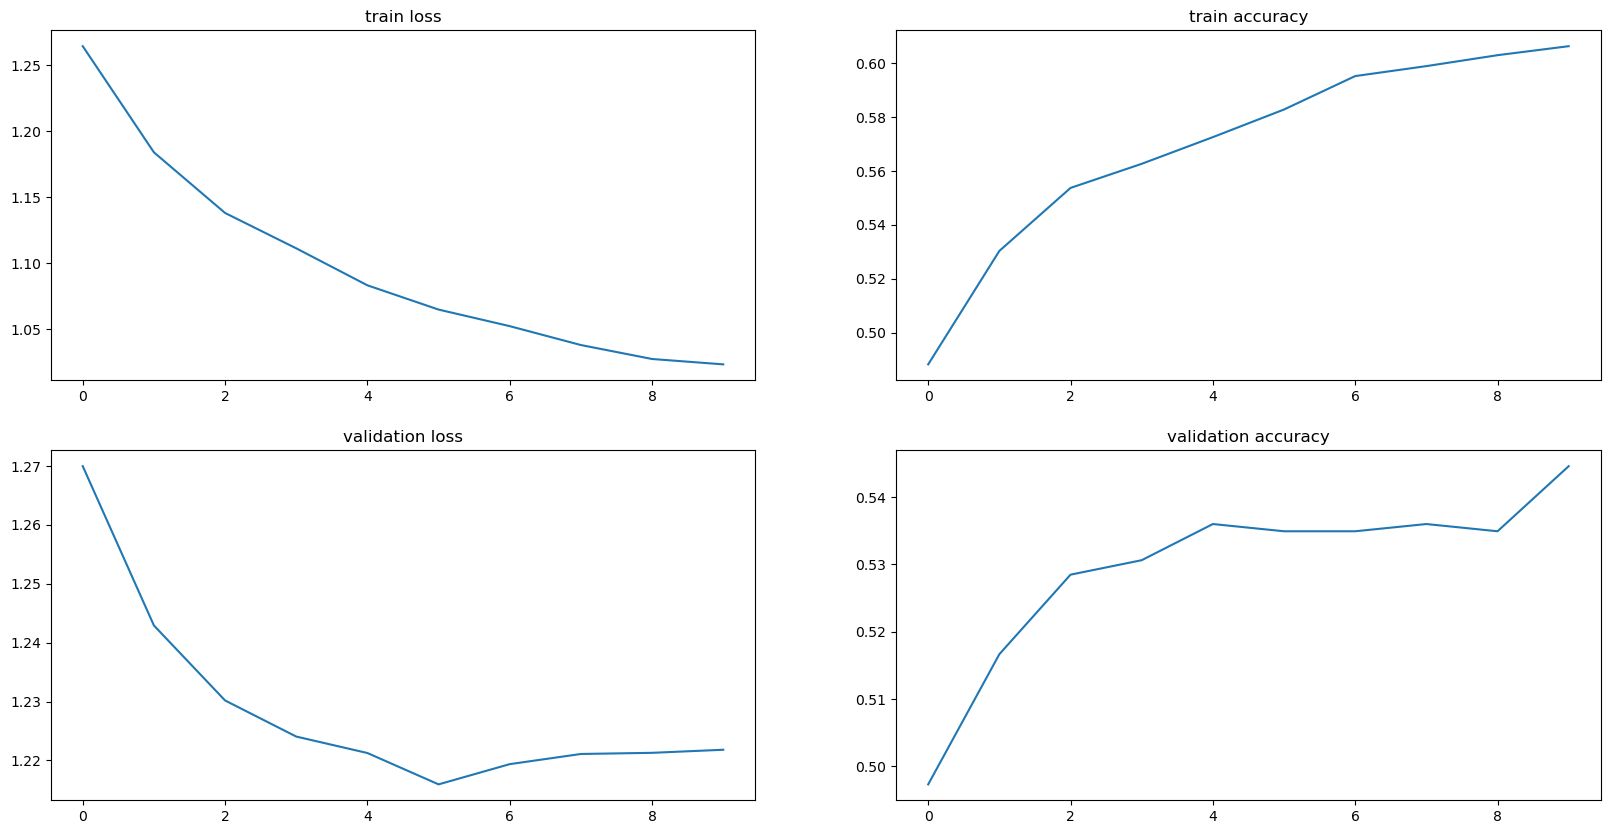

In [62]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [64]:
%%time

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
131/131 [==============================] - 240s 2s/step - loss: 1.0123 - accuracy: 0.6061 - val_loss: 1.2238 - val_accuracy: 0.5467
Epoch 2/20
131/131 [==============================] - 241s 2s/step - loss: 1.0077 - accuracy: 0.6073 - val_loss: 1.2247 - val_accuracy: 0.5435
Epoch 3/20
131/131 [==============================] - 246s 2s/step - loss: 1.0033 - accuracy: 0.6130 - val_loss: 1.2235 - val_accuracy: 0.5456
Epoch 4/20
131/131 [==============================] - 246s 2s/step - loss: 0.9994 - accuracy: 0.6150 - val_loss: 1.2298 - val_accuracy: 0.5467
Epoch 5/20
131/131 [==============================] - 245s 2s/step - loss: 0.9939 - accuracy: 0.6196 - val_loss: 1.2282 - val_accuracy: 0.5414
Epoch 6/20
131/131 [==============================] - 243s 2s/step - loss: 0.9914 - accuracy: 0.6125 - val_loss: 1.2336 - val_accuracy: 0.5467
Epoch 7/20
131/131 [==============================] - 244s 2s/step - loss: 0.9920 - accuracy: 0.6158 - val_loss: 1.2358 - val_accuracy: 0.5414